In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import dask

import shapely
import geopandas as gpd
import salem

import ecco_v4_py as ecco

import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as ticker
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
def get_gdf_patch(coords_patch):
    # Replace each pair of points by 10 points for projected map
    geometry = []
    segments = zip(coords_patch[:-2:2], coords_patch[1:-1:2], coords_patch[2::2], 
                   coords_patch[3::2])
    
    for line in [shapely.geometry.LineString([(x1, y1), (x2, y2)]) for (x1,y1,x2,y2) in segments]:
        for length in np.linspace(0,1,11):
            geometry.append( line.interpolate(length, normalized=True) )
        
    gdf_patch = gpd.GeoDataFrame([], geometry=geometry)
    
    # Convert Points to Polygo
    gdf_patch['geometry'] = gdf_patch['geometry'].apply(lambda x: x.coords[0])
    
    gdf_patch['shape_id'] = 0
    gdf_patch = gdf_patch.groupby('shape_id')['geometry'].apply(lambda x: shapely.geometry.Polygon(x.tolist())).reset_index()
    gdf_patch = gpd.GeoDataFrame(gdf_patch, geometry = 'geometry')
    
    # Salem uses this attribute:
    gdf_patch.crs = {'init': 'epsg:4326'}
    
    return gdf_patch

In [3]:
main = xr.open_zarr('/mnt/efs/data/ecco/zarr/eccov4r3_output/').rename({'face': 'tile'})
budg = xr.open_zarr('/mnt/efs/data/ecco/zarr/eccov4r3_budgets/').rename({'face': 'tile'})

In [4]:
# Volume (m^3)
vol = (main.rA*main.drF*main.hFacC).transpose('k','tile','j','i')

In [5]:
# Volume fluxes (m^3/s)
budg_vol = budg*vol

#### Freshwater budget

In [6]:
# Reference salinity
Sref = 35.0

In [7]:
# Density kg/m^3
rhoconst = 1029

# m^3 to Sverdrup
Sv = 10**-6

In [8]:
# Remove oceFWflx from WVELMASS
WVELMASS = main.WVELMASS.transpose('time','tile','k_l','j','i')
oceFWflx = main.oceFWflx.assign_coords(k_l=0).expand_dims('k_l').transpose('time','tile','k_l','j','i')

oceFWflx = (oceFWflx/rhoconst)
WVELMASS = xr.concat([WVELMASS.sel(k_l=0) + oceFWflx, WVELMASS[:,:,1:]], 
                     dim='k_l').transpose('time','tile','k_l','j','i')

In [9]:
grid = ecco.get_llc_grid(main)

In [10]:
SALT_at_u = grid.interp(main.SALT, 'X', boundary='extend')
SALT_at_v = grid.interp(main.SALT, 'Y', boundary='extend')
SALT_at_w = grid.interp(main.SALT, 'Z', boundary='extend')

In [11]:
# Freshwater advective (Eulerian) fluxes (m^3/s)
ADVx_FWe = main.UVELMASS*main.dyG*main.drF*(Sref-SALT_at_u)/Sref
ADVy_FWe = main.VVELMASS*main.dxG*main.drF*(Sref-SALT_at_v)/Sref
ADVr_FWe = WVELMASS*main.rA*(Sref-SALT_at_w)/Sref

In [12]:
# Freshwater advective (Bolus) fluxes (m^3/s)
ADVx_FWb = main.UVELSTAR*main.dyG*main.drF*(Sref-SALT_at_u)/Sref
ADVy_FWb = main.VVELSTAR*main.dxG*main.drF*(Sref-SALT_at_v)/Sref
ADVr_FWb = main.WVELSTAR*main.rA*(Sref-SALT_at_w)/Sref

In [13]:
# Liquid freshwater content (m^3)
lfwc = ((Sref - main.SALT)/Sref)*vol

In [14]:
def conv3d(ADVx, ADVy, ADVr):
    
    ADVxy_diff = grid.diff_2d_vector({'X' : ADVx, 'Y' : ADVy}, boundary = 'fill')
    adv_hConv = -(ADVxy_diff['X'] + ADVxy_diff['Y'])
    adv_vConv = grid.diff(ADVr, 'Z', boundary='fill')
    
    return adv_hConv, adv_vConv

In [15]:
# Freshwater tendency (m^3/s)
tendFw = grid.diff((Sref-main.SALT_snp)/Sref, 'T', boundary='fill', fill_value=0.0)*vol/main.dt

# Freshwater forcing (m^3/s)
forcFw = main.oceFWflx/rhoconst*main.rA

In [16]:
# Convergence
adv_hConvFWe, adv_vConvFWe = conv3d(ADVx_FWe, ADVy_FWe, ADVr_FWe)
adv_hConvFWb, adv_vConvFWb = conv3d(ADVx_FWb, ADVy_FWb, ADVr_FWb)
adv_hConvFw, adv_vConvFw = conv3d(ADVx_FWe+ADVx_FWb, ADVy_FWe+ADVy_FWb, ADVr_FWe+ADVr_FWb)

In [17]:
coords_SB = [-53., 47.46182,-52., 47.46182,-51., 47.46182,-50., 47.46182,-50., 48.12596,-49., 48.12596,-48., 48.12596,
             -47., 48.12596,-46., 48.12596,-45., 48.12596,-44., 48.12596,-43., 48.12596,-42., 48.12596,-41., 48.12596,
             -40., 48.12596,-39., 48.12596,-38., 48.12596,-37., 48.12596,-36., 48.12596,-35., 48.12596,-34., 48.12596,
             -33., 48.12596,-33., 47.46182,-32., 47.46182,-31., 47.46182,-30., 47.46182,-29., 47.46182,-28., 47.46182,
             -27., 47.46182,-26., 47.46182,-26., 46.78843,-25., 46.78843,-24., 46.78843,-23., 46.78843,-22., 46.78843,
             -22., 46.105774,-21., 46.105774,-20., 46.105774,-19., 46.105774,-18., 46.105774,-18., 45.41385,
             -17., 45.41385,-16., 45.41385,-15., 45.41385,-15., 44.712654,-14., 44.712654,-13., 44.712654,
             -13., 44.0022,-12., 44.0022,-11., 44.0022,-10., 44.0022,-10., 43.282494,-9.,43.282494]
coords_SB_to_EC = [-1.,43.282494,-1.,48.78087]
coords_EC = [-5.,48.78087,-5.,50.063072]
coords_EC_to_FS = [-5.,51.917812,-3.,51.917812,-3.,56.470177]
coords_FS = [-5.0209107, 58.686825,-5.037469 , 59.2385  ,-5.0590353, 59.784798,-5.085762 , 60.325672,
             -5.1178174 , 60.861084,-6.125942 , 60.84489 ,-6.166107, 61.37257,-6.2123857, 61.894703]
coords_IF = [-7.2812705, 62.386726,-7.344147, 62.895226,-8.362914, 62.86655,-8.436943, 63.36676,-9.458087, 63.333656,
             -10.47765, 63.298805,-10.567438, 63.787502,-11.588718,63.747887,-11.691477, 64.22754,
             -12.714039, 64.18291,-13.733949, 64.13652,-13.853814, 64.6033]
coords_DeS = [-24.503857, 65.66525,-24.697086, 66.05268,-25.656406, 65.969666,-26.60553, 65.88757,-26.80609, 66.25563,
              -27.73846 , 66.169136 ,-27.949457 , 66.52263 ,-28.86185 , 66.431946 ,-29.760134 , 66.34398,
              -29.971338 , 66.6755 ,-30.843836 , 66.58435 ,-31.699657 , 66.49765,-31.904171 , 66.80529 ,
              -32.727146 , 66.71687 ,-32.934757 , 67.00616 ,-33.719128 , 66.91664]
coords_DaS = [-54.23812 , 66.30245 ,-55.23425 , 66.384575 ,-55.432312 , 65.97625 ,-56.435608 , 66.052315 ,
              -57.4459 , 66.127075 ,-58.462845 , 66.20026 ,-59.486107 , 66.27162 ,-60.515358 , 66.34096 ,
              -60.687084 , 65.90322 ,-61.71775 , 65.96633]
coords_DaS_to_HS = [-65.88552 , 66.14171 , -65.522354 , 63.298805 ]
coords_HS = [-65.74028 , 61.797977, -65.796906, 61.28634 , -65.84604 , 60.769142, -65.88795, 60.24646,
             -65.922874 , 59.71838]
coords_HS_to_LG = [-65.461975,58.910896,-60,54,-56.5,52.814613]
coords_LG_to_SB = [-56.5,48.454567,-53., 47.46182]
coords_DeS_to_FrS = [-34.48089 , 66.8355,-35.11053 , 67.57883,-20.932653 , 78.87449]
coords_FrS = [-19.186508 , 79.03997,-17.391916 , 79.19493,-15.550275 , 79.33904,-13.663382 , 79.47198,
              -11.733448 , 79.5934,-11.066698 , 79.211174,-9.158151 , 79.31644,-7.2162747 , 79.40999,
              -5.244295 , 79.49161,-3.2457807 , 79.561066,-1.224616 , 79.618164,-0.9266135 , 79.21572,
              1.0404158 , 79.2584,3.0199282 , 79.28907,5.007849 , 79.30747,7.0 , 79.31361,8.992151 , 79.30747,
              10.980072 , 79.28907]
coords_FrS_to_SvN = [16.877235 , 79.16097,16.069956,76.879066]
coords_SvN = [16.739313, 76.64243, 16.468266, 76.222755, 18.017347, 76.16335, 17.723822, 75.74302,
              17.448696, 75.31985, 18.910137, 75.25662, 18.618252, 74.83322, 18.34467, 74.40739, 19.729927, 74.3413,
              19.444464, 73.91592, 19.177204, 73.48885, 18.92733, 73.06082, 20.221594, 72.99534, 19.96517, 72.569916,
              19.726929, 72.14657, 20.968075, 72.07988, 20.731846, 71.66982, 20.513678, 71.26436, 20.307493, 70.85302,
              21.488281, 70.78876, 21.278511, 70.37436]
coords_SvN_to_SN = [21.080824 , 69.95405,20.894821 , 69.52784,7.0 , 61.499973]
coords_SN = [4.9789214 , 60.954185 ,3.9684584 , 60.95079 ,3.9770377 , 60.40301,2.9694877 , 60.398922,
             2.9789946 , 59.846252,1.9738591 , 59.84185,0.96880066 , 59.836487,0.9801969 , 59.280174,
             -0.022954563 , 59.27508,-0.012811167 , 58.714504,-1.0145311 , 58.710075,-1.0064105 , 58.145473,
             -2.00715 , 58.142113,-2.0017748 , 57.573742]
coords_SN_to_FS = [-2.5004644 , 57.28708, -3.500000, 56.736153, -4.500550, 57.284992, -5.0209107, 58.686825]
coords_LG = [-56.0, 53.69125,-55.0, 53.69125,-55.0, 54.264557,-55.0 ,54.829044,-54.0,54.829044,-54.0,55.384766,
             -53.0 , 55.384766,-53.0 , 55.931786,-52.0 , 55.931786,-52.0 , 56.470177,-51.0 , 56.470177,-51.0 , 57.0,
             -50.0 , 57.0,-49.997044 , 57.494728,-48.9972 , 57.491325,-48.98871 , 57.978825,-47.98942 , 57.972424,
             -46.990215,57.96642,-46.9778, 58.443645,-45.979767, 58.435368,-45.9637, 58.905373,-44.967514, 58.89538,
             -44.94873 , 59.35802,-43.955177 , 59.346916,-43.93474 , 59.802036]
coords_LG_to_DaS = [-43.808777 , 61.561226,-53.250584 , 66.21951]

In [18]:
#coords_spna = [-9.4, 50,-56.8, 50,-67.5, 62.3,-61.6, 66.7,-35, 66.7,-22.1, 66.1,-3.8, 59,-9.4, 50]
coords_spna = coords_SB+coords_SB_to_EC+coords_EC+coords_EC_to_FS+coords_FS+coords_IF+coords_DeS+coords_DaS+\
                coords_DaS_to_HS+coords_HS+coords_HS_to_LG+coords_LG_to_SB

#coords_nsea = [-3.8, 59,-22.1, 66.1,-35, 66.7,-29, 70,-25, 80,20, 80,20, 70,11, 64,5, 60,-3.8,59]
coords_nsea = coords_FS+coords_IF+coords_DeS+coords_DeS_to_FrS+coords_FrS+coords_FrS_to_SvN+coords_SvN+\
                coords_SvN_to_SN+coords_SN+coords_SN_to_FS

coords_lsea = coords_DaS+coords_DaS_to_HS+coords_HS+coords_HS_to_LG+coords_LG+coords_LG_to_DaS

In [19]:
gdf_spna = get_gdf_patch(coords_spna)
gdf_nsea = get_gdf_patch(coords_nsea)
gdf_lsea = get_gdf_patch(coords_lsea)

In [20]:
# Create mask for SPNA
df = main.coords.to_dataset().get(['XC','YC']).to_dataframe()
gdf = gpd.GeoDataFrame(df[[]],geometry=[shapely.geometry.Point(xy) for xy in zip(df.XC, df.YC)])

gdf['mask_spna'] = gdf.geometry.intersects(gdf_spna.iloc[0,1])
gdf['mask_nsea'] = gdf.geometry.intersects(gdf_nsea.iloc[0,1])
gdf['mask_lsea'] = gdf.geometry.intersects(gdf_lsea.iloc[0,1])

mask_spna = gdf[['mask_spna']].to_xarray().mask_spna.transpose('tile','j','i')
main['mask_spna'] = mask_spna.where(main.hFacC[0].values==1,0)

mask_nsea = gdf[['mask_nsea']].to_xarray().mask_nsea.transpose('tile','j','i')
main['mask_nsea'] = mask_nsea.where(main.hFacC[0].values==1,0)

mask_lsea = gdf[['mask_lsea']].to_xarray().mask_lsea.transpose('tile','j','i')
main['mask_lsea'] = mask_lsea.where(main.hFacC[0].values==1,0)

In [28]:
np.set_printoptions(formatter={"float_kind": lambda x: "%g" % x})
print(main.Z.values)

[-5 -15 -25 -35 -45 -55 -65 -75.005 -85.025 -95.095 -105.31 -115.87
 -127.15 -139.74 -154.47 -172.4 -194.735 -222.71 -257.47 -299.93 -350.68
 -409.93 -477.47 -552.71 -634.735 -722.4 -814.47 -909.74 -1007.16 -1105.91
 -1205.54 -1306.2 -1409.15 -1517.09 -1634.18 -1765.14 -1914.15 -2084.03
 -2276.23 -2491.25 -2729.25 -2990.25 -3274.25 -3581.25 -3911.25 -4264.25
 -4640.25 -5039.25 -5461.25 -5906.25]


In [24]:
np.set_printoptions(formatter={"float_kind": lambda x: "%g" % x})
print(main.Zl.values)

[0 -10 -20 -30 -40 -50 -60 -70 -80.01 -90.04 -100.15 -110.47 -121.27
 -133.03 -146.45 -162.49 -182.31 -207.16 -238.26 -276.68 -323.18 -378.18
 -441.68 -513.26 -592.16 -677.31 -767.49 -861.45 -958.03 -1056.28 -1155.53
 -1255.54 -1356.87 -1461.43 -1572.76 -1695.59 -1834.68 -1993.62 -2174.45
 -2378 -2604.5 -2854 -3126.5 -3422 -3740.5 -4082 -4446.5 -4834 -5244.5
 -5678]


In [27]:
np.set_printoptions(formatter={"float_kind": lambda x: "%g" % x})
print(main.Zu.values)

[-10 -20 -30 -40 -50 -60 -70 -80.01 -90.04 -100.15 -110.47 -121.27 -133.03
 -146.45 -162.49 -182.31 -207.16 -238.26 -276.68 -323.18 -378.18 -441.68
 -513.26 -592.16 -677.31 -767.49 -861.45 -958.03 -1056.28 -1155.53
 -1255.54 -1356.87 -1461.43 -1572.76 -1695.59 -1834.68 -1993.62 -2174.45
 -2378 -2604.5 -2854 -3126.5 -3422 -3740.5 -4082 -4446.5 -4834 -5244.5
 -5678 -6134.5]


In [31]:
print(main.Zl.values[22],main.Z.values[22],main.Zu.values[22])

-441.68 -477.47 -513.26


In [34]:
depth_bnds[-1].values

array([407.624, 490.949], dtype=float32)

In [22]:
k=22

In [26]:
tendFw[:,:k+1].Z.values

array([-5, -15, -25, -35, -45, -55, -65, -75.005, -85.025, -95.095,
       -105.31, -115.87, -127.15, -139.74, -154.47, -172.4, -194.735,
       -222.71, -257.47, -299.93, -350.68, -409.93, -477.47],
      dtype=float32)

In [27]:
terms = ['tendFw', 'forcFw', 
         'adv_hConvFWe', 'adv_vConvFWe', 'adv_ConvFWe', 
         'adv_hConvFWb', 'adv_vConvFWb', 'adv_ConvFWb', 
         'adv_hConvFw', 'adv_vConvFw', 'adv_ConvFw', 
         'totalFw', 
         'w_trspFWe', 'w_trspFWb', 
         'lfwc', 'psal']

budg_fw = []

for mask in [main.mask_spna,main.mask_nsea,main.mask_lsea]:
        
    # Freshwater tendency (m^3/s)
    tendFw_mask = (tendFw[:,:k+1]*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    # Freshwater forcing (m^3/s)
    forcFw_mask = (forcFw*mask.where(mask==1)).sum(dim=['tile','j','i'])
    
    # Convergence of eularian advection (m^3/s)
    adv_hConvFWe_mask = (adv_hConvFWe[:,:k+1]*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    adv_vConvFWe_mask = (adv_vConvFWe[:,:,:k+1]*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    adv_ConvFWe_mask = ((adv_hConvFWe+adv_vConvFWe)[:,:k+1]*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    # Convergence of bolus advection (m^3/s)
    adv_hConvFWb_mask = (adv_hConvFWb[:,:k+1]*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    adv_vConvFWb_mask = (adv_vConvFWb[:,:k+1]*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    adv_ConvFWb_mask = ((adv_hConvFWb+adv_vConvFWb)[:,:k+1]*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
        
    # Convergence of total advection (m^3/s)
    adv_hConvFw_mask = (adv_hConvFw[:,:k+1]*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    adv_vConvFw_mask = (adv_vConvFw[:,:,:k+1]*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    adv_ConvFw_mask = ((adv_hConvFw+adv_vConvFw)[:,:k+1]*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    # Sum of terms (m^3/s)
    totalFw_mask = forcFw_mask + adv_ConvFw_mask
    
    # Vertical eularian transport (m^3/s)
    w_trspFWe = (ADVr_FWe[:,:,k+1]*mask.where(mask==1)).sum(dim=['tile','j','i'])
    
    # Vertical bolus transport (m^3/s)
    w_trspFWb = (ADVr_FWb[:,k+1]*mask.where(mask==1)).sum(dim=['tile','j','i'])
    
    # Liquid freshwater content (m^3)
    lfwc_mask = (lfwc[:,:k+1]*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    # Average salinity (psu)
    psal = ((main.SALT*vol)[:,:k+1]*mask.where(mask==1)).sum(dim=['tile','k','j','i'])\
            /(vol[:k+1]*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    results = dask.compute(tendFw_mask.reset_coords(drop=True)*Sv, forcFw_mask.reset_coords(drop=True)*Sv, 
                           adv_hConvFWe_mask.reset_coords(drop=True)*Sv, adv_vConvFWe_mask.reset_coords(drop=True)*Sv,
                           adv_ConvFWe_mask.reset_coords(drop=True)*Sv,
                           adv_hConvFWb_mask.reset_coords(drop=True)*Sv, adv_vConvFWb_mask.reset_coords(drop=True)*Sv,
                           adv_ConvFWb_mask.reset_coords(drop=True)*Sv,
                           adv_hConvFw_mask.reset_coords(drop=True)*Sv, adv_vConvFw_mask.reset_coords(drop=True)*Sv,
                           adv_ConvFw_mask.reset_coords(drop=True)*Sv,
                           totalFw_mask.reset_coords(drop=True)*Sv, 
                           w_trspFWe.reset_coords(drop=True)*Sv, w_trspFWb.reset_coords(drop=True)*Sv,
                           lfwc_mask.reset_coords(drop=True), psal.reset_coords(drop=True))
    
    budg = xr.concat(results,pd.Index(terms, name='term'))
    budg_fw.append(budg)

In [28]:
region = ['spna', 'nsea', 'lsea']
budg_fw = xr.concat(budg_fw,pd.Index(region, name='region'))

In [29]:
dif_ConvFw = budg_fw.sel(term='tendFw') - budg_fw.sel(term='totalFw')
budg_fw = xr.concat([budg_fw, dif_ConvFw.assign_coords(term='dif_ConvFw')], dim='term')

#### Save to netcdf

In [30]:
ds = budg_fw.reset_coords(drop=True).to_dataset(name='budg_fw')

In [31]:
ds.to_netcdf('/mnt/efs/data/ecco/ecco_budg_fw_500m.nc', format='NETCDF4')

#### Average salinity, LFWC and time-integrated tendency

In [116]:
psal = budg_fw.sel(region='lsea',term='psal') - budg_fw.sel(region='lsea',term='psal').mean('time')
lfwc = budg_fw.sel(region='lsea',term='lfwc') - budg_fw.sel(region='lsea',term='lfwc').mean('time')

tend = (budg_fw.sel(region='lsea',term='tendFw').isel(time=slice(1, -1))\
        *main.isel(time=slice(1, -1)).dt).cumsum(dim='time')
tend = tend - tend.mean('time')

In [117]:
psal_anom = psal.groupby('time.month') - psal.groupby('time.month').mean('time')
lfwc_anom = lfwc.groupby('time.month') - lfwc.groupby('time.month').mean('time')
tend_anom = tend.groupby('time.month') - tend.groupby('time.month').mean('time')

### ECCOv4 interp

In [33]:
from dateutil import parser
from dateutil.relativedelta import relativedelta

In [34]:
def ncdatetime(month):
    basedate = parser.parse("1992-01-01")
    _dt = (basedate + relativedelta(months=int(month))).replace(day=15)
    return _dt

In [87]:
ec = xr.open_dataset('/mnt/efs/data/ecco/SALT.0001.nc')

ec['i3'].values = ec.lat.values[:,0]
ec['i4'].values = ec.lon.values[0,:]
ec = ec.swap_dims({'i1':'tim','i2':'dep'}).rename({'lat':'lat0','lon':'lon0'}).rename({'i3':'lat','i4':'lon'})
ec.tim.values = [ncdatetime(n-1) for n in ec.i1.values]
ec = ec.reset_coords(drop=True)
ec = ec.rename({'dep':'depth','tim':'time'})

In [88]:
nc = xr.open_dataset('/mnt/efs/data/ecco/ecco_interp_area.nc')
#ec.area.attrs= {'units': 'm^2','long_name': 'Grid area'}

In [89]:
# Salinity field
sal_ec = ec.SALT.sel(time=slice('1992-01-01','2015-12-31'),depth=slice(0,500),
                     lat=slice(50,70),lon=slice(-70,-40)).salem.roi(shape=gdf_lsea.loc[[0]])

In [95]:
# Layer thickness
dz = main.drF.swap_dims({'k':'Z'}).reset_coords(drop=True).rename({'Z':'depth'})
dz['depth'].values = dz['depth'].values*-1

# Area
area_ec = nc.area.sel(lat=slice(50,70),lon=slice(-70,-40)).salem.roi(shape=gdf_lsea.loc[[0]])

In [110]:
# Volume
vol_ec = dz*area_ec

# Average salinity in the Labrador Sea
psal_ec = (sal_ec*vol_ec).sum(dim=['depth','lat','lon'])/((sal_ec/sal_ec)*vol_ec).sum(dim=['depth','lat','lon'])

In [130]:

psal_ec_anom = psal_ec.groupby('time.month') - psal_ec.groupby('time.month').mean('time')

### EN4

In [48]:
en = xr.open_dataset('/mnt/efs/data/salinity.nc')
nc = xr.open_dataset('/mnt/efs/data/hadobs_en4_area.nc')
en['area'] = nc.area
en.area.attrs= {'units': 'm^2','long_name': 'Grid area'}

In [49]:
# Salinity field
sal_en = en.salinity.sel(time=slice('1992-01-01','2015-12-31'),depth=slice(0,500),
                         lat=slice(50,70),lon=slice(-70,-40)).salem.roi(shape=gdf_lsea.loc[[0]])

In [118]:
# Layer thickness
depth_bnds = en.depth_bnds.sel(depth=slice(0,500))
dz = (depth_bnds[:,1]-depth_bnds[:,0])

# Area
area_en = en.area.sel(lat=slice(50,70),lon=slice(-70,-40)).salem.roi(shape=gdf_lsea.loc[[0]])

# Volume
vol_en = dz*area_en

# Average salinity in the Labrador Sea
psal_en = (sal_en*vol_en).sum(dim=['depth','lat','lon'])/((sal_en/sal_en)*vol_en).sum(dim=['depth','lat','lon'])

In [119]:
psal_en_anom = psal_en.groupby('time.month') - psal_en.groupby('time.month').mean('time')

In [122]:
ts = [pd.to_datetime('2008-06-01'),pd.to_datetime('2010-06-01'),pd.to_datetime('2011-06-01'),
      pd.to_datetime('2012-06-01'),pd.to_datetime('2015-06-01')]

te = [pd.to_datetime('2008-10-31'),pd.to_datetime('2010-10-31'),pd.to_datetime('2011-10-31'),
      pd.to_datetime('2012-10-31'),pd.to_datetime('2015-10-31')]

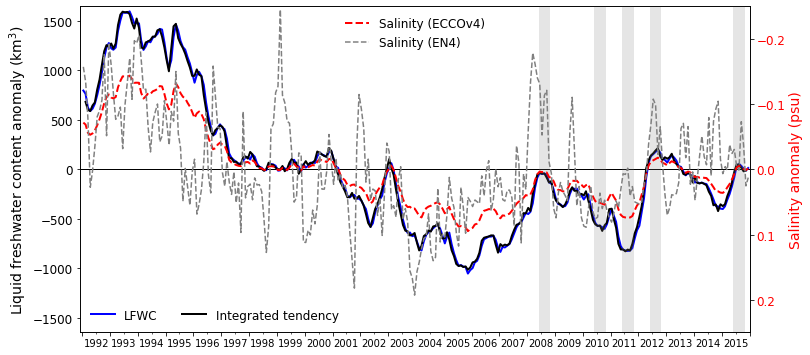

In [132]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')

ax1.plot(lfwc_anom.time, lfwc_anom*1e-9, lw=2, color='b',linestyle='-',label='LFWC')
ax1.plot(tend_anom.time, tend_anom*1e-3, lw=2, color='k',linestyle='-',label='Integrated tendency')

ax1.set_xlim(['1991-12-01','2016-01-01'])
ax1.set_ylim([-1650,1650])
ax1.yaxis.set_tick_params(labelsize=12)
ax1.set_ylabel('Liquid freshwater content anomaly (km$^3$)',fontsize=14)
ax1.legend(loc='lower left',frameon=False,ncol=2,fontsize=12)
for tl in ax1.get_yticklabels():
    tl.set_color('k')
    tl.set_fontsize(12)

ax1.xaxis.set_major_locator(dates.YearLocator())
ax1.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax1.xaxis.set_major_formatter(ticker.NullFormatter())
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax1.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)
    
ax2 = ax1.twinx()
ax2.plot(psal_anom.time, psal_anom, lw=2, color='r',linestyle='--',label='Salinity (ECCOv4)')
#ax2.plot(psal_ec_anom.time, psal_ec_anom, lw=1.5, color='orange',linestyle='--',label='Salinity (ECCOv4-interp)')

ax2.plot(psal_en_anom.time, psal_en_anom, lw=1.5, color='grey', linestyle='--',label='Salinity (EN4)')


ax2.set_xlim(['1991-12-01','2016-01-01'])
ax2.set_ylim([-0.25,0.25])
ax2.invert_yaxis()

ax2.yaxis.set_tick_params(labelsize=12)
ax2.set_ylabel(r'Salinity anomaly (psu)', color='r', fontsize=14)
for tl in ax2.get_yticklabels():
    tl.set_color('r')
    tl.set_fontsize(12)

ax2.legend(loc='upper center',frameon=False,fontsize=12)

ax2.xaxis.set_major_locator(dates.YearLocator())
ax2.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax2.xaxis.set_major_formatter(ticker.NullFormatter())
ax2.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax2.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

for a,b in zip(ts,te):
    ax2.fill([a,b,b,a],[-1,-1,1,1],'grey', alpha=0.2, edgecolor='None')

#plt.savefig('/mnt/efs/figure.png')
#plt.savefig('/mnt/efs/figure.eps')
plt.savefig('/mnt/efs/figure.pdf')
plt.show()

In [216]:
budgFw_fd = xr.open_dataset('/mnt/efs/data/ecco/ecco_budg_fw.nc').budg_fw

In [217]:
lfwc_fd = budgFw_fd.sel(region='lsea',term='lfwc') - budgFw_fd.sel(region='lsea',term='lfwc').mean('time')

In [218]:
lfwc_fd_anom = lfwc_fd.groupby('time.month') - lfwc_fd.groupby('time.month').mean('time')


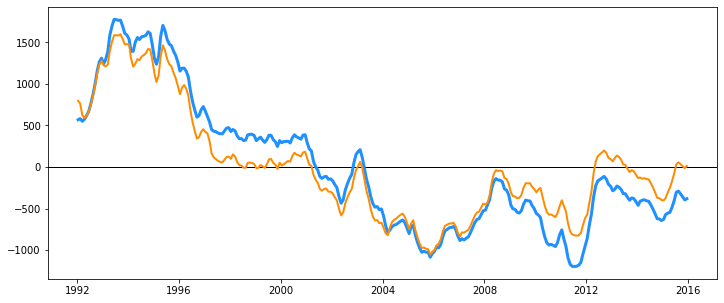

In [222]:
fig = plt.figure(figsize=(12,5))
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1, color = 'k')
plt.plot(lfwc_fd_anom.time,lfwc_fd_anom*1e-3, lw=3, color='dodgerblue',label='Full depth')
plt.plot(lfwc_anom.time,lfwc_anom*1e-9, lw=2, color='darkorange',label='Upper 500 m')
plt.show()

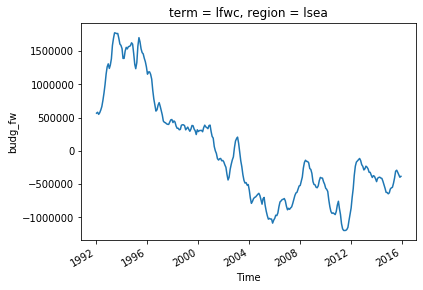

In [219]:
lfwc_fd_anom.plot()

In [137]:
df = lfwc_anom.to_dataframe(name='lfwc').reset_index()
df.time = pd.DatetimeIndex(df.time)
df = df.drop(columns=['term','region','month'])
df = df.set_index(['time'])

In [140]:
btsf = xr.open_dataset('/mnt/efs/data/ecco/barotropic_streamfunction_north_atlantic.nc')

In [144]:
btsf.time.values = [ncdatetime(n-1) for n in btsf.time.values+1]

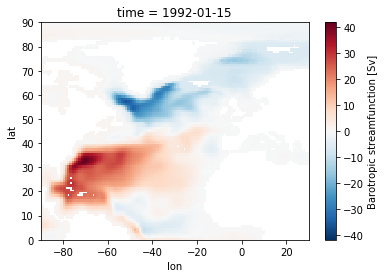

In [148]:
btsf.psi[0].plot()

In [150]:
psi_ann = btsf.psi.groupby('time.year').mean('time')

In [154]:
lfwc_ann = lfwc_anom.groupby('time.year').mean('time')

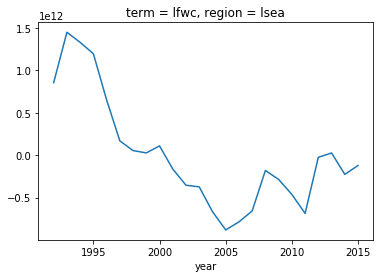

In [155]:
lfwc_ann.plot()

In [158]:
def get_corr(data):
    return np.corrcoef(data,lfwc_ann.sel(year=psi_ann.year))[1,0]

In [164]:
from scipy.stats.stats import pearsonr

In [162]:
def pval_dropna(y, x):
    df = pd.DataFrame({'y': y,'x': x}).dropna()
    return pearsonr(df.y.values,df.x.values)

def get_pval(data):
    try:
        model = pval_dropna(data,lfwc_ann.sel(year=psi_ann.year))
        pval = model[1]
        return pval
    
    except ValueError:
        return np.nan
    
    except RuntimeError:
        return np.nan
    
    except IndexError:
        return np.nan

In [159]:
corr = xr.DataArray(np.apply_along_axis(get_corr, 2, psi_ann.transpose('lat','lon','year')),
                    coords=[psi_ann.lat.values.astype(float),psi_ann.lon.values.astype(float)],
                    dims=['lat','lon'])

In [165]:
pval = xr.DataArray(np.apply_along_axis(get_pval, 2, psi_ann.transpose('lat','lon','year')),
                    coords=[psi_ann.lat.values.astype(float),psi_ann.lon.values.astype(float)],
                    dims=['lat','lon'])

In [171]:
import cartopy

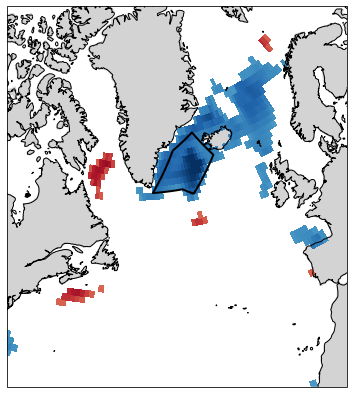

In [199]:
fig = plt.figure(figsize=(10,7))

ax = plt.axes(projection=cartopy.crs.LambertConformal(central_longitude=-50.0,central_latitude=50.0))
ax.set_extent([-72, -10, 25, 82], cartopy.crs.Geodetic())
ax.add_feature(cartopy.feature.LAND,color='lightgrey')
ax.coastlines(resolution='50m',linewidth=1.0)

p = ax.pcolormesh(corr.lon-0.5, corr.lat-0.5,np.ma.masked_invalid(corr.where(pval < 0.05)),
                  cmap='RdBu_r',vmin=-0.7,vmax=0.7,transform=cartopy.crs.PlateCarree())

ax.add_geometries([gdf_patch['geometry'][0]], cartopy.crs.PlateCarree(), facecolor='none', edgecolor=(0,0,0,1), 
                  linewidth=2, linestyle='-')

plt.show()

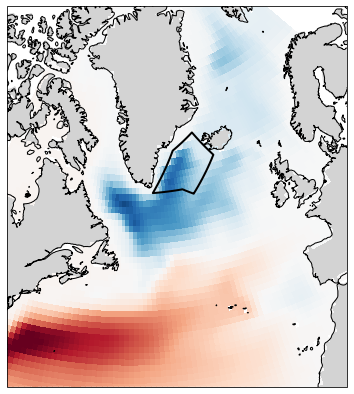

In [200]:
fig = plt.figure(figsize=(10,7))

ax = plt.axes(projection=cartopy.crs.LambertConformal(central_longitude=-50.0,central_latitude=50.0))
ax.set_extent([-72, -10, 25, 82], cartopy.crs.Geodetic())
ax.add_feature(cartopy.feature.LAND,color='lightgrey')
ax.coastlines(resolution='50m',linewidth=1.0)

p = ax.pcolormesh(btsf.lon-0.5, btsf.lat-0.5,np.ma.masked_invalid(btsf.psi.mean('time')),
                  cmap='RdBu_r',vmin=-40,vmax=40,transform=cartopy.crs.PlateCarree())

ax.add_geometries([gdf_patch['geometry'][0]], cartopy.crs.PlateCarree(), facecolor='none', edgecolor=(0,0,0,1), 
                  linewidth=2, linestyle='-')

plt.show()

In [201]:
psi_patch = btsf.psi.salem.roi(shape=gdf_patch.loc[[0]])

In [203]:
# Load gridded area
ds_area = xr.open_dataset('/mnt/efs/data/area1x1.nc').rename({'LATITUDE':'lat', 'LONGITUDE': 'lon'})

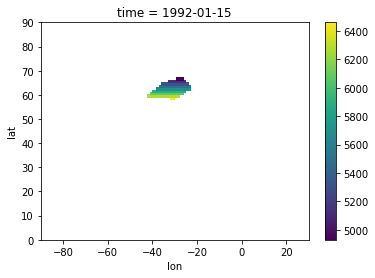

In [208]:
((psi_patch/psi_patch)*ds_area.AREA)[0].plot()

In [204]:
area_patch = ((psi_patch/psi_patch)*ds_area.AREA).sum(dim=['lat','lon'])

In [209]:
psi_patch_mean = (psi_patch*ds_area.AREA/area_patch).sum(dim=['lat','lon'])

In [212]:
psi_patch_ann = psi_patch_mean.groupby('time.year').mean('time')

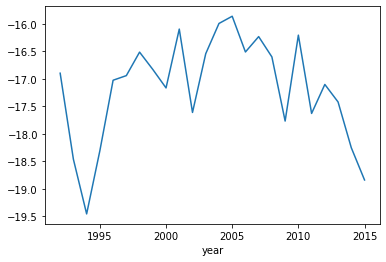

In [213]:
psi_patch_ann.plot()

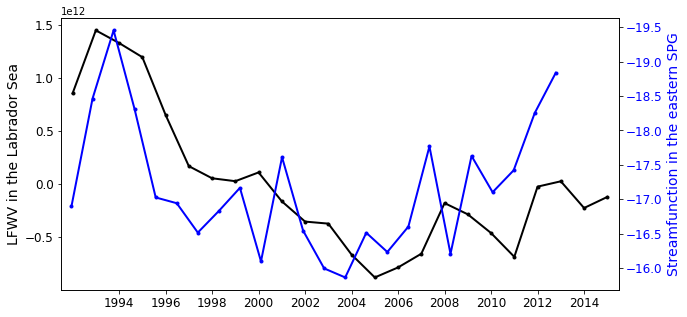

In [215]:
fig, ax1 = plt.subplots(figsize=(10,5))

ax1.plot(lfwc_ann.year, lfwc_ann, lw=2, color='k',linestyle='-',marker='.')

ax1.set_xlim([1991.5,2015.5])
ax1.set_xticks(np.arange(1994,2020,2))
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_ylabel(r'LFWV in the Labrador Sea',color='k',fontsize=14)
for tl in ax1.get_yticklabels():
    tl.set_color('k')
    tl.set_fontsize(12)

ax2 = ax1.twinx()

ax2.plot(psi_patch_ann.year, psi_patch_ann, lw=2, color='b',linestyle='-',marker='.')

ax2.set_xlim([1991.5,2015.5])
ax2.set_xticks(np.arange(1994,2020,2))
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_ylabel(r'Streamfunction in the eastern SPG',color='b',fontsize=14)
for tl in ax2.get_yticklabels():
    tl.set_color('b')
    tl.set_fontsize(12)
ax2.invert_yaxis()
#plt.savefig('/mnt/efs/figure.png')
#plt.savefig('/mnt/efs/figure.eps')
plt.show()

In [195]:
coords = [-43, 59,
          -34, 59,
          -31, 58,
          -22, 63,
          -27, 67,
          -35, 65,
          -43, 59]

In [196]:
def get_gdf_patch(coords_patch):
    # Replace each pair of points by 10 points for projected map
    geometry = []
    segments = zip(coords_patch[:-2:2], coords_patch[1:-1:2], coords_patch[2::2], 
                   coords_patch[3::2])
    
    for line in [shapely.geometry.LineString([(x1, y1), (x2, y2)]) for (x1,y1,x2,y2) in segments]:
        for length in np.linspace(0,1,11):
            geometry.append( line.interpolate(length, normalized=True) )
        
    gdf_patch = gpd.GeoDataFrame([], geometry=geometry)
    
    # Convert Points to Polygo
    gdf_patch['geometry'] = gdf_patch['geometry'].apply(lambda x: x.coords[0])
    
    gdf_patch['shape_id'] = 0
    gdf_patch = gdf_patch.groupby('shape_id')['geometry'].apply(lambda x: shapely.geometry.Polygon(x.tolist())).reset_index()
    gdf_patch = gpd.GeoDataFrame(gdf_patch, geometry = 'geometry')
    
    # Salem uses this attribute:
    gdf_patch.crs = {'init': 'epsg:4326'}
    
    return gdf_patch

In [197]:
gdf_patch = get_gdf_patch(coords)

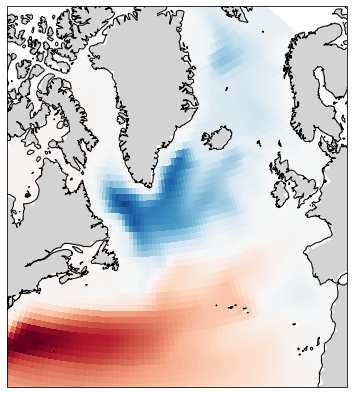

In [176]:
fig = plt.figure(figsize=(10,7))

ax = plt.axes(projection=cartopy.crs.LambertConformal(central_longitude=-50.0,central_latitude=50.0))
ax.set_extent([-72, -10, 25, 82], cartopy.crs.Geodetic())
ax.add_feature(cartopy.feature.LAND,color='lightgrey')
ax.coastlines(resolution='50m',linewidth=1.0)



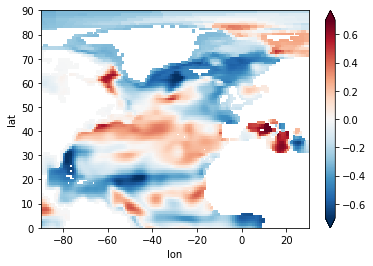

In [161]:
btsf.psi[0].plot()

In [166]:
corr

<xarray.DataArray (lat: 90, lon: 120)>
array([[-0.169112, -0.145748, -0.12004, ..., nan, nan, nan],
       [-0.273492, -0.22456, -0.188514, ..., nan, nan, nan],
       [-0.310703, -0.254958, -0.221504, ..., nan, nan, nan],
       ...,
       [-0.314081, -0.314081, -0.314081, ..., -0.0788823, -0.0788823,
        -0.0788823],
       [-0.322678, -0.322678, -0.322678, ..., -0.0895075, -0.0895075,
        -0.0895075],
       [-0.335055, -0.335055, -0.335055, ..., -0.181111, -0.181111,
        -0.181111]])
Coordinates:
  * lat      (lat) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 85.5 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 26.5 27.5 28.5 29.5